In [ ]:
# Lab 3 Exercises for COMP 6321 Machine Learning

In this lab you'll cluster and fit mixture models to data using the popular _scikit-learn_ package. Lab3 requires a good understanding of Numpy and Matplotlib. Please complete Lab1 before attempting Lab3.

**Run the code cell below** to import the required packages.

In [278]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import sklearn.cluster         # For KMeans class
import sklearn.mixture         # For GaussianMixture class
import sklearn.preprocessing   # For scale function
import mpl_toolkits.mplot3d    # For enabling projection='3d' feature in Matplotlib

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Introduction
This "introduction" group of code cells has no exercises. The goal is to provide you with examples. Run the code cells and learn from them.

Load the image *ladybug.png* as a Numpy array. The image should already have been unzipped into the same directory as this notebook.

In [279]:
image = plt.imread('ladybug.png')
print(image.shape)

(100, 100, 3)


Notice the shape of the array. Entry _image[y,x]_ in the array is a length-3 vector representing the RGB value of pixel at location $(x, y)$ in the image.

Plot the image using Matplotlib's _imshow_ function.

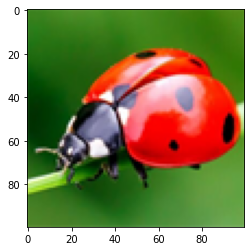

In [280]:
plt.imshow(image);

Reshape the image into a 2-dimensional matrix suitable for clustering the pixels by their RGB colour value. The data should be in array format 

$$
\begin{bmatrix}
r_1 & g_1 & b_1\\
r_2 & g_2 & b_2\\
\vdots & \vdots & \vdots\\
r_N & g_N & b_N
\end{bmatrix}
$$

where $N=10000$ and each $\begin{bmatrix} r_i & g_i & b_i \end{bmatrix}$ is the colour of pixel with index $i$.

In [281]:
RGB = image.reshape(-1, 3)
print(RGB.shape)
print(RGB)

(10000, 3)
[[0.30588236 0.5568628  0.2       ]
 [0.27058825 0.53333336 0.16470589]
 [0.27058825 0.53333336 0.16470589]
 ...
 [0.4509804  0.6745098  0.34901962]
 [0.4392157  0.6784314  0.34509805]
 [0.46666667 0.6901961  0.37254903]]


The top-left pixel (index $i=0$) has colour $\begin{bmatrix} 0.31 & 0.56 & 0.20 \end{bmatrix}$, which is green-ish. Makes sense! 

Plot the pixel RGB values in 3-dimensional colour space.

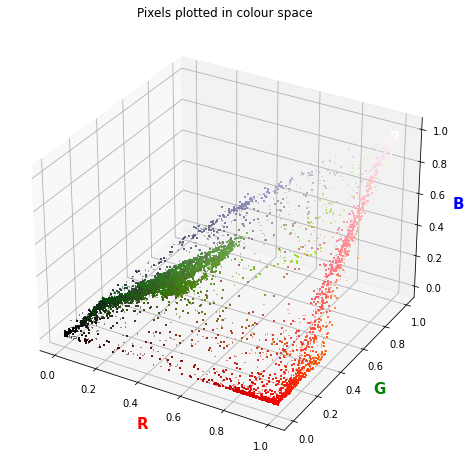

In [282]:
def plot_colour_space(RGB, title=None, hold=False, **kwargs):
    """
    Plots Nx3 matrix RGB in 3 dimensions.
    
    The keyword arguments are passed to Matplotlib's scatter() function.
    If hold=True, the points will be added to the previous plot. Otherwise a new plot is generated.
    """
    if hold:
        ax = plt.gca()
    else:
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
    kwargs.setdefault('alpha', 1.0)
    ax.scatter(*RGB.T, **kwargs)
    ax.set_xlabel('R', color='r', fontweight='bold', fontsize=15)
    ax.set_ylabel('G', color='g', fontweight='bold', fontsize=15)
    ax.set_zlabel('B', color='b', fontweight='bold', fontsize=15)
    if title is not None:
        ax.set_title(title)
    
plot_colour_space(RGB, c=RGB, s=0.5, marker='s', title="Pixels plotted in colour space")

Run the *K*-means clustering algorithm with *K*=5, using each RGB pixel colour vector as a data point.

In [283]:
def run_kmeans(data, k):
    """
    Runs K-means on an NxD array using k clusters.
    
    Returns a KxD matrix of centroids and a length-N vector of labels (cluster assignments).
    """
    kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=0).fit(data)
    return kmeans.cluster_centers_, kmeans.labels_

centroids, labels = run_kmeans(RGB, k=5)

print(centroids)
print(labels, len(labels))

[[0.91830087 0.11951411 0.04882491]
 [0.2199334  0.4692984  0.09348438]
 [0.8889071  0.67274106 0.6811432 ]
 [0.07332402 0.23711258 0.04663853]
 [0.39092913 0.5740281  0.2899987 ]]
[4 1 1 ... 4 4 4] 10000


The centroids array has shape (5,3) because there are *K*=5 centroids, a 3-dimensional vector. The labels are given as integer indices, as in the "alternate formulation for *K*-means" from Lecture 2.

Plot the centroids in RGB colour space.

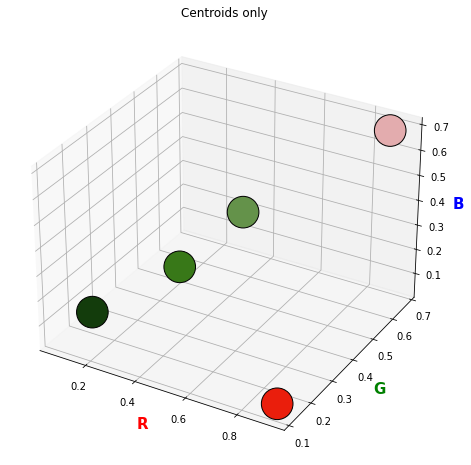

In [284]:
plot_colour_space(centroids, facecolors=centroids, edgecolor='black', s=1000, title="Centroids only")

Plot the pixels in RGB space but with colour matching that of the centroid the pixel was assigned to. Include the centroids themselves in the same plot.

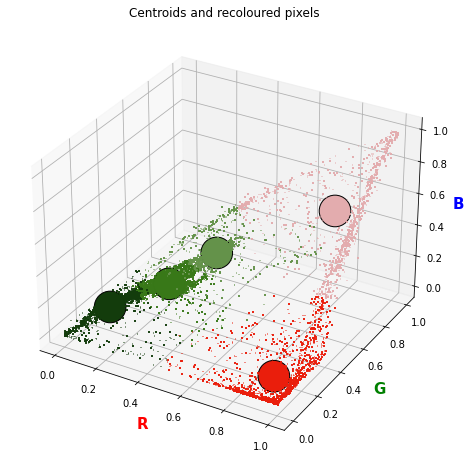

In [285]:
# Create a new (10000,3) ndarray where values in row i are copied from centroids[labels[i],:]
RGB_recoloured = centroids[labels]

# Plot the re-coloured pixels, along with the corresponding centroids
plot_colour_space(RGB, c=RGB_recoloured, marker='s', s=0.5, title="Centroids and recoloured pixels")
plot_colour_space(centroids, facecolors=centroids, edgecolor='black', s=1000, hold=True)

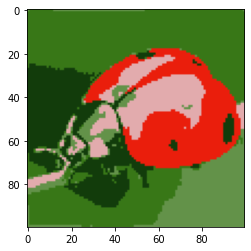

In [286]:
plt.imshow(RGB_recoloured.reshape(image.shape));

Compare the above to Figure 9.3 (p.429) of the Bishop textbook.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 1. Spatial clustering with K-means

Exercises 1.1&ndash;1.4 ask you to apply scikit-learn's **[sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)** object to the pixels from the introduction, but on slightly different data.

It requires that you have already **run the code cells from the introduction**.

In [287]:
assert 'image' in globals(), "Did you run the code cells from introduction?"
assert 'RGB' in globals(), "Did you run the code cells from introduction?"

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.1 &mdash; Add pixel location features

The introduction showed you how to cluster pixels by colour, like Figure 9.3 (p.429) of the Bishop book. The data that we clustered was an array of 3-dimensional features $\begin{bmatrix} r_i & g_i & b_i \end{bmatrix}$, stored in the array object referenced by variable *RGB*. 


In exercises 1.2&ndash;1.4, you'll be asked to cluster the pixels by _colour_ (rgb) and _location_ (xy). To do this, you must first add pixel location features to the data.


**Write a few lines of code** to create a new array called *RGBXY* where each row is a 5-dimensional feature vector $\begin{bmatrix} r_i & g_i & b_i & x_i & y_i\end{bmatrix}$, with $(x_i, y_i)$ being the location in the image where pixel $i$ came from in the original image. Use the *image* variable to get the height and width of the original ladybug image. Then use the [**np.arange**](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) and [**np.meshgrid**](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) function to generate two arrays, each containing the individual $x_i$ and $y_i$ values respectively. Finally, use a matrix stacking function like [**np.column_stack**](https://numpy.org/doc/stable/reference/generated/numpy.column_stack.html) to create the new array object *RGBXY* from the original *RGB* data and your new pixel location arrays.

If you have done everything correctly, your data with extra "pixel location features" should look like this:
```python
>>> RGBXY
[[ 0.30588236  0.55686277  0.2         0.          0.        ]
 [ 0.27058825  0.53333336  0.16470589  1.          0.        ]
 [ 0.27058825  0.53333336  0.16470589  2.          0.        ]
 ...
 [ 0.4509804   0.67450982  0.34901962 97.         99.        ]
 [ 0.43921569  0.67843139  0.34509805 98.         99.        ]
 [ 0.46666667  0.6901961   0.37254903 99.         99.        ]]
```

In [288]:
x2d, y2d = np.meshgrid(np.arange(0, 100, dtype="float32"), np.arange(0, 100, dtype="float32"))
RGBXY = np.column_stack((RGB, x2d.ravel(), y2d.ravel()))

**Check your answer** by running the code cell below.

In [289]:
assert 'RGBXY' in globals(), "You didn't create a variable called RGBXY"
assert isinstance(RGBXY, np.ndarray), "Expected RGBXY to be ndarray"
assert RGBXY.dtype == RGB.dtype, "RGBXY has wrong dtype"
assert RGBXY.shape == (100*100,5), "RGBXY has wrong shape"
assert np.array_equal(RGBXY[99:101],
                      np.array([[0.38039216, 0.57647060, 0.15686275, 99., 0.],
                                [0.25490198, 0.52156866, 0.14509805,  0., 1.]], dtype=np.float32)), "RGBXY wrong data"                      
print("Correct!")

Correct!


<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.2 &mdash; Cluster pixels spatially

**Write a few lines of code** to do the following:
1. Cluster the $\begin{bmatrix} r_i & g_i & b_i & x_i & y_i\end{bmatrix}$ values that are currently stored in the _RGBXY_ variable. Use *K*=6 clusters. You can use *sklearn.cluster.KMeans* directly or you can use the _run_kmeans_ function from the introduction.
2. Plot the re-coloured image, where each pixel's colour has been replaced by its corresponding centroid colour, as we did in the introduction.

Your plot should look like this:
![image](img/fig-ladybug-kmeans-spatial.png)

_Hint:_ Your _RGBXY_ array has shape (10000,5), but the _imshow_ function expects an array of shape (*height*, *width*, 3). So you will need to slice out colour data and reshape it into a form that _imshow_ expects.

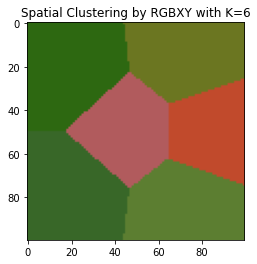

In [290]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=6)
km.fit(RGBXY)
centroids, labels = km.cluster_centers_, km.labels_
plt.title("Spatial Clustering by RGBXY with K=6")
plt.imshow(centroids[labels][:,:3].reshape(image.shape))

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.3 &mdash; More clusters!

**Repeat Exercise 1.2** but this time use *K*=50 clusters. It may take a few seconds. If you do not understand the result that you see, ask for insight from a TA or from someone else.

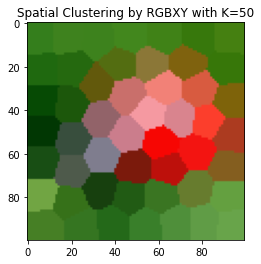

In [291]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=50)
km.fit(RGBXY)
centroids, labels = km.cluster_centers_, km.labels_
plt.title("Spatial Clustering by RGBXY with K=50")
plt.imshow(centroids[labels][:,:3].reshape(image.shape))

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.4 &mdash; Feature scaling

**Repeat Exercise 1.3** but this time scale the $x$ and $y$ features by a factor of 0.02 before clustering. Your answer should use Numpy's "broadcasting" mechanism to achieve the scaling in a single step.

Be sure to store the transformed values in a new array called _RGBXY_scaled_ rather than modifying the original _RGBXY_ array. Otherwise you may end up having to re-run the code cell that generated the _RGBXY_ variable.

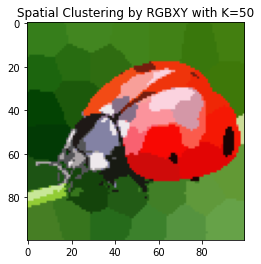

In [292]:
from sklearn.cluster import KMeans

height, width = image.shape[0], image.shape[1]
x2d, y2d = np.meshgrid(np.arange(0, width, dtype="float32"), np.arange(0, height, dtype="float32"))
RGBXY_scaled = np.column_stack((RGB, 0.02 * x2d.ravel(), 0.02 * y2d.ravel()))

km = KMeans(n_clusters=50)
km.fit(RGBXY_scaled)
centroids, labels = km.cluster_centers_, km.labels_
plt.title("Spatial Clustering by RGBXY with K=50")
plt.imshow(centroids[labels][:, :3].reshape(image.shape))

The purpose of this exercise is to see that the clustering method is very sensitive to the scale of different features. If you were to scale the _XY_ components all the way to zero, you would be back to clustering _only by colour_, as we did in the introduction.

Before continuing, try scaling $(x,y)$ by different values, such as $(0.05, 0.02)$ and see how that effects the pixel clusters.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 2. Selecting *K* in *K*-means

Exercises 2.1&ndash;2.2 ask you to generate synthetic data and to apply the "elbow" heuristic for selecting optimal *K* in *K*-means.

**Run the code cell below** to define a function for sampling data from a mixture of Gaussians. 

In [293]:
def sample_gmm(means, covs=None, weights=None, N=1):
    """
    Samples a K-component D-dimensional Gaussian mixture.
    
    The means are KxD.
    The covariances are KxDxD. The default covariance is the DxD identity matrix.
    The weights are length K and must sum to 1. The default is uniform weights.
    
    Returns (X, c) where X is an NxD array of samples and c is a length-N vector
    of component indices, i.e. X[i] was sampled from mixture component c[i].
    """
    K, D = means.shape
    
    # Valudate inputs and set default values if needed
    if covs is None:
        covs = np.tile(np.eye(D), (K,1,1))  # Stack of K D-dimensional identity matricies
    if weights is None:
        weights = np.full(K, 1/K)
    assert covs.shape == (K,D,D)
    
    # Sample a vector of component choices in proportion to weights, one for each sample
    c = np.random.choice(K, N, p=weights)  # choice() checks that weights has shape (K,1) and sums to 1
    
    # Fill an array of N samples, one component at a time
    X = np.empty((N,D))
    for k in range(K):
        X[k==c] = np.random.multivariate_normal(means[k], covs[k], np.count_nonzero(k==c))
    return X, c

<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.1 &mdash; Generate synthetic GMM data

**Write a few lines of code** to generate 1000 samples from a 9-component Gaussian mixture, where the means are arranged in a 3x3 grid as shown below.

![image](img/fig-synthetic-gmm-data-1.png)

Use a single call to the *sample_gmm* function to generate your data. That means you must build a _means_ matrix with shape (9,2) containing the 9 means. You should know how to do this procedurally, either with for-loops or with a call to the _np.meshgrid_ and *np.column_stack* functions. (Do not write out all 9 of the mean vectors by hand.)

Create a variable called _X_ that refers to your samples, and create a variable called _c_ that refers to the mixture component indices (this value is directly returned by *sample_gmm*, so just store the result).

The `np.random.seed(0)` ensures you always generate the same data each time you run the code cell.

In [294]:
np.random.seed(0)

a, b = np.meshgrid([-5, 0, 5], [-5, 0, 5])
means = np.vstack((a.ravel(), b.ravel())).T
X, c = sample_gmm(means=means, N=1000)

**Plot your data** by running the code cell below.

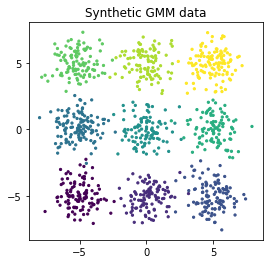

In [295]:
assert 'X' in globals(), "You must create a variable called 'X' that refers to your samples!"
assert 'c' in globals(), "You must create a variable called 'c' that refers to your component indices!"
assert X.shape == (1000,2), "X should have shape (1000, 2)!"
assert c.shape == (1000,), "c should have shape (1000,)!"
plt.scatter(*X.T, c=c, s=5)     # Plot each point (X[i,0], X[i,1]) using colour index c[i] and point size 5
plt.title("Synthetic GMM data")
plt.xticks([-5, 0, 5])
plt.yticks([-5, 0, 5])
plt.gca().set_aspect('equal')   # It's important to see this data with equal scales on each axis

<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.2 &mdash; Choosing *K* with *K*-means

When applying *K*-means, it may be difficult to choose the best *K* for a particular data set. Recall the "elbow curve" method for selecting *K* as reviewed in Lecture 2. You are asked to apply this method to select a "good" *K* for the data set generated in Exercise 2.1.

**Write a few lines of code** to generate a plot of *K* ($x$-axis) versus the corresponding *K*-means objective value ($y$-axis) for each choice of $K \in \{2, \ldots 15\}$. Use the **[sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)** object in your answer. Once you have called the _fit_ method on a _KMeans_ object you can recover the final objective value (at convergence) from the object's *intertia_* attribute (as in `kmeans_object.inertia_`).

If you have done this correctly, you should see a 'kink' at *K*=9, which makes sense given that the data was indeed generated from 9 clusters.

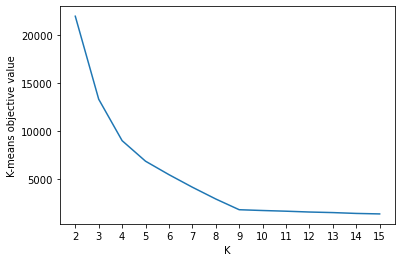

In [296]:
from sklearn.cluster import KMeans

x_axis = np.arange(2, 16)
y_axis = [KMeans(n_clusters=x).fit(X).inertia_ for x in x_axis]

plt.xlabel("K")
plt.ylabel("K-means objective value")
plt.xticks(x_axis)
plt.plot(x_axis, y_axis)

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 3. Fitting a Gaussian Mixture Model (GMM)

Exercises 3.1&ndash;3.4 ask you fit 2D data with scikit-learn's **[sklearn.mixture.GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)** object.

**Run the code cell below** to define a function that will help to visualize the placement and shape of GMM components.

In [297]:
def plot_gmm(gmm):
    """
    Plots the placement of components in a Gaussian Mixture.
    
    The gmm object should be of type sklean.mixture.GaussianMixture
    """
    ax = plt.gca()
    for weight, mean, cov in zip(gmm.weights_, gmm.means_, gmm.covariances_):
        v, w = np.linalg.eigh(cov)
        v = 2*np.sqrt(2*v)
        u = w[0] / np.linalg.norm(w[0])
        angle = 180 * (1 + np.arctan(u[1]/u[0]) / np.pi)  # Ellipse() function needs degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle, edgecolor='k',
                                  facecolor='none', linestyle='--', linewidth=2, alpha=0.8)
        ax.add_artist(ell)

<div style="border-bottom: 3px solid black;"></div>

### Exercise 3.1 &mdash; Fit a GMM to non-overlapping, isotropic data

**Write fitting code** to fit a **[sklearn.mixture.GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)** object to the synthetic data from Exercise 2.1. Use 9 mixture components in your answer. You should use the argument *random_state=0* to ensure reproducibility. Create a variable called _gmm_ that refers to your new *GaussianMixture* object.

In [298]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=9, random_state=0, n_init=5).fit(X)

**Write plotting code** using the *plot_gmm* function provided. Once you have the ellipses plotting correctly, use the **[predict](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.predict)** method of the *GaussianMixture* object and use them to colour the points in the scatter plot. Your plot should look similar to:
![image](img/fig-synthetic-gmm-fit-1.png)
If you find that the GMM components do not fit perfectly to the data, try adding *n_init=5* to the arguments of your _GaussianMixture_ object. This will run the EM algorithm multiple times from different randomized initializations, and may give a higher chance of getting the 'right' clustering.

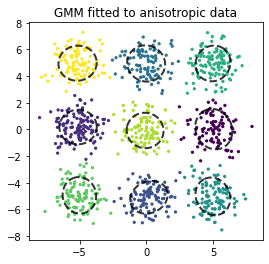

In [299]:
plot_gmm(gmm)
predicted = gmm.predict(X)

plt.scatter(*X.T, s=5, c=predicted)
plt.title('GMM fitted to anisotropic data')
plt.gca().set_aspect('equal')

<div style="border-bottom: 3px solid black;"></div>

### Exercise 3.2 &mdash; Generate overlapping, anisotropic synthetic GMM data

**Write some code** to generate 500 samples from 2-dimensional 3-component Gaussian mixture having the following parameters:

$$
\begin{align}
\pi_1 = 0.5, \quad &\boldsymbol{\mu}_1 = \begin{bmatrix} -2.0 & 0.0 \end{bmatrix}, &\boldsymbol{\Sigma}_1 = \begin{bmatrix}\phantom{-}2.0 & \phantom{-}1.0 \\ \phantom{-}1.0 & \phantom{-}2.0\end{bmatrix}\\
\pi_2 = 0.3, \quad &\boldsymbol{\mu}_2 = \begin{bmatrix} \phantom{-}2.0 & 0.0 \end{bmatrix}, &\boldsymbol{\Sigma}_2 = \begin{bmatrix}1.0 & -0.9 \\ -0.9 & 1.0\end{bmatrix}\\
\pi_3 = 0.2, \quad &\boldsymbol{\mu}_3 = \begin{bmatrix} \phantom{-}0.0 & 0.0 \end{bmatrix}, &\boldsymbol{\Sigma}_3 = \begin{bmatrix}10.0 & \phantom{-}0.0 \\ \phantom{-}0.0 & 10.0\end{bmatrix}\\
\end{align}
$$

Use the *sample_gmm* function from part 2. Create a variable called _X_ that refers to your samples, and create a variable called _c_ that refers to the mixture component indices (this value is directly returned by *sample_gmm*, so just store the result).

In [300]:
np.random.seed(0)

w, m, c = (
    np.array([0.5, 0.3, 0.2]),
    np.array([[-2.0, 0.0], [2.0, 0.0], [0.0, 0.0]]),
    np.array(
        [
            [[2.0, 1.0], [1.0, 2.0]],
            [[1.0, -0.9], [-0.9, 1.0]],
            [[10.0, 0.0], [0.0, 10.0]],
        ]
    ),
)

X, c = sample_gmm(means=m, covs=c, weights=w, N=500)

**Plot your data** by running the code cell below. The plot should look like this:
![image](img/fig-synthetic-gmm-data-2.png)

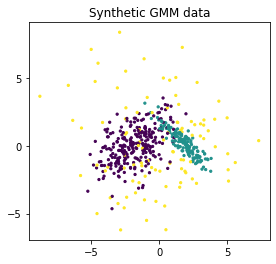

In [301]:
assert 'X' in globals(), "You must create a variable called 'X' that refers to your samples!"
assert 'c' in globals(), "You must create a variable called 'c' that refers to your component indices!"
assert X.shape == (500,2), "X should have shape (500, 2)!"
assert c.shape == (500,), "c should have shape (500,)!"
plt.scatter(*X.T, c=c, s=5)     # Plot each point (X[i,0], X[i,1]) using colour index c[i] and point size 5
plt.title("Synthetic GMM data")
plt.xticks([-5, 0, 5])
plt.yticks([-5, 0, 5])
plt.gca().set_aspect('equal')   # It's important to see this data with equal scales on each axis

<div style="border-bottom: 3px solid black;"></div>

### Exercise 3.3 &mdash; Fit a GMM to the anisotropic, overlapping data

**Write fitting code** to fit a **[sklearn.mixture.GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)** object to the synthetic data you generated in Exercise 3.2. Use 3 mixture components in your answer. You should use the argument *random_state=0* to ensure reproducibility. Create a variable called _gmm_ that refers to your new *GaussianMixture* object.

In [302]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(X)

**Write plotting code** (like Exercise 3.1) using the **[predict](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.predict)** method. Your plot should look like this (colours may differ):
![image](img/fig-synthetic-gmm-fit-2.png)

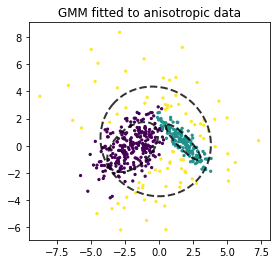

In [303]:
predicted = gmm.predict(X)
plot_gmm(gmm)

plt.scatter(*X.T, s=5, c=predicted)
plt.title('GMM fitted to anisotropic data')
plt.gca().set_aspect('equal')

**Write plotting code** to visualize the probability $p(z_{ik} \mid \mathbf{x}_i)$ that component $k$ generated data point $\mathbf{x}_i$. Use the **[predict_proba](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.predict_proba)** method of the _GaussianMixture_ object to get the probabilities. Because there are $K=3$ components, you can visualize these probabilities by using $\begin{bmatrix} p(z_{i1} \mid \mathbf{x}_i) & p(z_{i2} \mid \mathbf{x}_i) & p(z_{i3} \mid \mathbf{x}_i) \end{bmatrix}$ as the values colour $\begin{bmatrix} r_i & g_i & b_i \end{bmatrix}$ for data point $i$. Your plot should look like this:
![image](img/fig-synthetic-gmm-fit-2-probs.png)

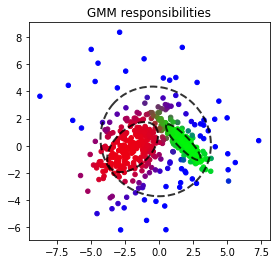

In [304]:
plot_gmm(gmm)
predicted = gmm.predict_proba(X)

plt.scatter(*X.T, s=20, c=predicted)
plt.title('GMM responsibilities')
plt.gca().set_aspect('equal')

<div style="border-bottom: 3px solid black;"></div>

### Exercise 3.4 &mdash; Sample from spatially clustered pixels using a GMM

**Write fitting code** to fit a **[sklearn.mixture.GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)** object to the _RGBXY_ data (the ladybug) that you generated in Exercise 1.2. Use **15** mixture components in your answer. You should use the argument *random_state=0* to ensure reproducibility. Create a variable called _gmm_ that refers to your new *GaussianMixture* object.

In [305]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=15, random_state=0).fit(RGBXY)

**Generate 5000 samples** from your fitted mixture model by using the **[sample](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.sample)** method of the _GaussianMixture_ object. The resulting sample matrix should have shape (5000,5) where each row is a vector $\begin{bmatrix}r & g & b & x & y\end{bmatrix}$. Create a variable _X_ to refer to your new samples. Note that the _sample_ function also returns a component membership vector, but you can ignore it.

In [306]:
X, _ = gmm.sample(n_samples=5000)

**Plot the samples** as if they were pixels at location $(x,y)$ with colour $(r,g,b)$. Use a single call to Matplotlib's _scatter_ function. Your ladybug should look something like this:
![image](img/fig-synthetic-ladybug.png)

*Hint:* The _scatter_ function will fail if you use any colour values outside range $[0.0,1.0]$, yet there's no guarantee that a Gaussian will produce values within this range. Use the **[np.clip](https://numpy.org/devdocs/reference/generated/numpy.clip.html)** function to clamp the $(r,g,b)$ values to this range.

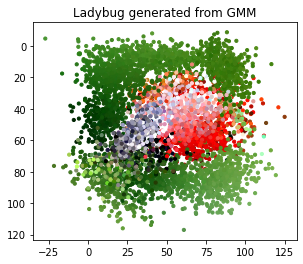

In [307]:
res = np.array_split(X, 2, axis=1)
colors, shape = np.clip(res[0], 0.0, 1.0), 10
plt.scatter(*res[1].T, c=colors, s=shape)
plt.title("Ladybug generated from GMM")

# Keep these lines at the end.
plt.gca().invert_yaxis()         # This line makes sure the ladybug appears upright!
plt.gca().set_aspect('equal')    # This line makes sure the ladybug isn't squished!

This final exercise was designed to show:
* how to train a GMM on 5-dimensional data (RGBXY);
* how to visualize 5 dimensional samples in a 2D plot, by using a combination of colour and space;
* that sampling from a generative model, such as a GMM, is a good way to see whether the samples it generates are "realistic" or whether they're missing important aspects of the real data; and
* that a Gaussian or a GMM, when used as a generative model, can produce samples that have values outside the range of the original training data (for example, negative XY coordinates).